In [15]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [16]:
#Data Cleanup and Preparation
fuel_access = pd.read_csv('access-to-clean-fuels-and-technologies-for-cooking.csv')
fuel_access.rename(columns={'Entity':'Country',
                            'Proportion of population with primary reliance on clean fuels and technologies for cooking (%) - Residence area type: Total':'Proportion using clean cooking fuels'},
                   inplace=True)
fuel_access['Year'] = fuel_access['Year'].astype('int64')
fuel_access_grouped = fuel_access.groupby('Year')['Proportion using clean cooking fuels'].mean()

co2 = pd.read_csv("co2_pcap_cons.csv")
co2 = co2[['country'] + [str(year) for year in range(1990, 2022)]]

co2_melted = co2.melt(id_vars='country')
co2_melted.rename(columns={'variable': 'Year', 'country':'Country'}, inplace=True)
co2_melted['Year'] = co2_melted['Year'].astype('int64')

population = pd.read_csv('population.csv')
population.rename(columns={'Entity': 'Country'}, inplace=True)
population = population[(population['Year'] >= 1990) & (population['Year'] <= 2021)]
population['Year'] = population['Year'].astype('int64')

co2_and_population = co2_melted.merge(population, how='inner', on=['Country', 'Year'])
co2_and_population.rename(columns={'Population - Sex: all - Age: all - Variant: estimates': 'Estimated Population', 'Year_x':'Year'}, inplace=True)
co2_and_population = co2_and_population.drop(['Code'], axis=1)

co2_and_population_and_cleancooking = co2_and_population.merge(fuel_access, how='inner', on=['Country', 'Year'])
co2_and_population_and_cleancooking.rename(columns={'Year_x':'Year', 'value':'co2 emmitted per capita'}, inplace=True)
co2_and_population_and_cleancooking = co2_and_population_and_cleancooking.drop(['Code'], axis=1)
co2_and_population_and_cleancooking.dropna()

top_5_countries = co2_and_population_and_cleancooking[co2_and_population_and_cleancooking['Country'].isin(["Qatar", "Belgium", "Kuwait", "Singapore", "Luxembourg"])]
top_5_countries.loc[:, 'Year'] = pd.to_numeric(top_5_countries['Year'], errors='coerce')



In [17]:
#Function 1
def largest_adjacent_co2_difference(filtered_data):
    filtered_data['co2 emmitted per capita'] = pd.to_numeric(filtered_data['co2 emmitted per capita'], errors='coerce')
    filtered_data['Year'] = pd.to_numeric(filtered_data['Year'], errors='coerce')
    results = []
    for country in filtered_data['Country'].unique():
        country_data = filtered_data[filtered_data['Country'] == country].sort_values(by='Year')
        differences = country_data['co2 emmitted per capita'].diff().abs()
        max_diff = 0
        for k in range(0, len(differences)):  
            if differences.iloc[k] > max_diff:
                max_diff = differences.iloc[k]
                year_start = country_data.iloc[k - 1]['Year']
                year_end = country_data.iloc[k]['Year']
        results.append({'Country': country,'Largest Adjacent CO2 Difference': max_diff,'Year Start': year_start,'Year End': year_end})
    return pd.DataFrame(results)
largest_adjacent_co2_difference(top_5_countries)

,Country,Largest Adjacent CO2 Difference,Year Start,Year End
0,Belgium,3.2,2008,2009
1,Kuwait,8.3,1992,1993
2,Luxembourg,13.5,2008,2009
3,Qatar,21.2,1998,1999
4,Singapore,20.0,2008,2009


In [18]:
#Function 2
def parameter_estimates(tbl, x_column, y_column):
    """ returns all parameters for a specific table, x, and y"""
    tbl[x_column] = pd.to_numeric(tbl[x_column], errors='coerce')
    tbl[y_column] = pd.to_numeric(tbl[y_column], errors='coerce')
    x = tbl[x_column]
    y = tbl[y_column]
    r = x.corr(y)
    slope = r * (y.std() / x.std())
    intercept = y.mean() - slope * x.mean()
    y_pred = slope * x + intercept
    rmse = ((y - y_pred) ** 2).mean() ** 0.5
    R2 = r**2
    print('r =', r, ', slope =', slope, ', intercept =', intercept, ', rmse =', rmse, ', R2 =', R2)

Text(0.5, 0, 'Year')

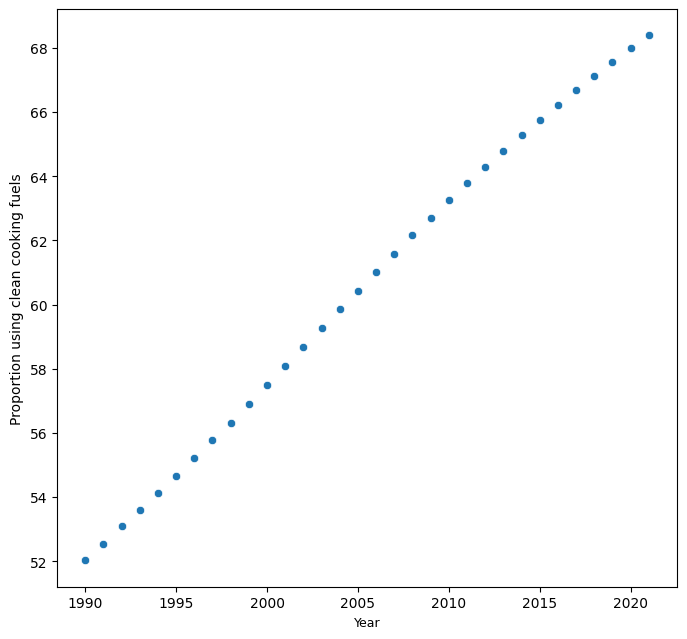

In [19]:
#Figure 1 
fig, ax = plt.subplots(1, figsize=(8,7.5))

sns.scatterplot(fuel_access_grouped)
ax.set_xlabel('Year', fontsize=9)

Text(0.5, 0, 'co2 emmitted per capita (tonnes)')

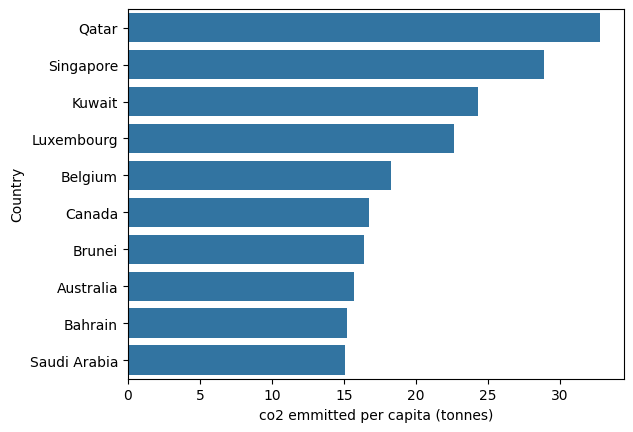

In [20]:
#Figure 2 
co2_and_population_and_cleancooking['co2 emmitted per capita'] =pd.to_numeric(co2_and_population_and_cleancooking['co2 emmitted per capita'
], errors = 'coerce')
top_ten_table = co2_and_population_and_cleancooking.groupby('Country')['co2 emmitted per capita'].mean()
ax = sns.barplot(top_ten_table.sort_values(ascending=False)[0:10], orient='h')
ax.set_xlabel('co2 emmitted per capita (tonnes)')

Text(0.5, 1.0, 'Top 5 countries 1990-2021')

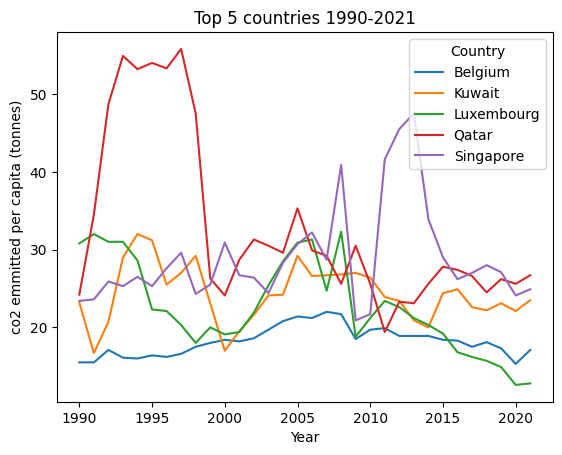

In [21]:
#Figure 3
top_ten_table = co2_and_population_and_cleancooking.groupby(['Country', 'Year'])['co2 emmitted per capita'].mean().reset_index()
avg_countries = top_ten_table.groupby(['Country'])['co2 emmitted per capita'].mean().reset_index()
top_five_countries = avg_countries.sort_values(by = 'co2 emmitted per capita', ascending = False)[0:5]
lineplot_data = top_ten_table[top_ten_table['Country'].isin(top_five_countries['Country'])]
ax = sns.lineplot(data = lineplot_data, x = 'Year', y = 'co2 emmitted per capita', hue = 'Country')
ax.set_ylabel('co2 emmitted per capita (tonnes)')
ax.set_title("Top 5 countries 1990-2021")

In [22]:
Turkey = co2_and_population_and_cleancooking[co2_and_population_and_cleancooking['Country'] == 'Turkey']

parameter_estimates(Turkey, 'Year','co2 emmitted per capita')
parameter_estimates(Turkey, 'Year','Estimated Population')
parameter_estimates(Turkey, 'Year','Proportion using clean cooking fuels')
parameter_estimates(Turkey, 'co2 emmitted per capita','Estimated Population')
parameter_estimates(Turkey, 'co2 emmitted per capita','Proportion using clean cooking fuels')
parameter_estimates(Turkey, 'Estimated Population','Proportion using clean cooking fuels')

r_data = {
    'Year and co2 emmitted per capita': [0.780917628796288],
    'Year and Estimated Population': [0.9935359645607055],
    'Year and Proportion using clean cooking fuel': [0.94649502998716],
    'co2 emmitted per capita and Estimated Population': [0.7538055399638709],
    'co2 emmitted per capita and Proportion using clean cooking fuels':[0.6916488944041737],
    'Estimated Population and Proportion using clean cooking fuels' : [0.9156291017710009],
}
r_df = pd.DataFrame(r_data)

r = 0.780917628796288 , slope = 0.05689882697947214 , intercept = -109.73309750733138 , rmse = 0.42021438264616523 , R2 = 0.609832342964817
r = 0.9935359645607055 , slope = 968730.5256598238 , intercept = -1872226557.6482766 , rmse = 1021951.9770544146 , R2 = 0.9871137128755714
r = 0.94649502998716 , slope = 0.4004490469208211 , intercept = -711.7021260997068 , rmse = 1.2606653971281712 , R2 = 0.8958528417903948
r = 0.7538055399638709 , slope = 10087432.255358228 , intercept = 26404776.86466936 , rmse = 5915567.89262049 , R2 = 0.568222792080223
r = 0.6916488944041737 , slope = 4.016211056178535 , intercept = 73.81747360157847 , rmse = 2.8213306696723683 , R2 = 0.47837819313051577
r = 0.9156291017710009 , slope = 3.9730965746697183e-07 , intercept = 63.36327020109388 , rmse = 1.5704646665606825 , R2 = 0.8383766520099699


Text(0.5, 0, 'r - value')

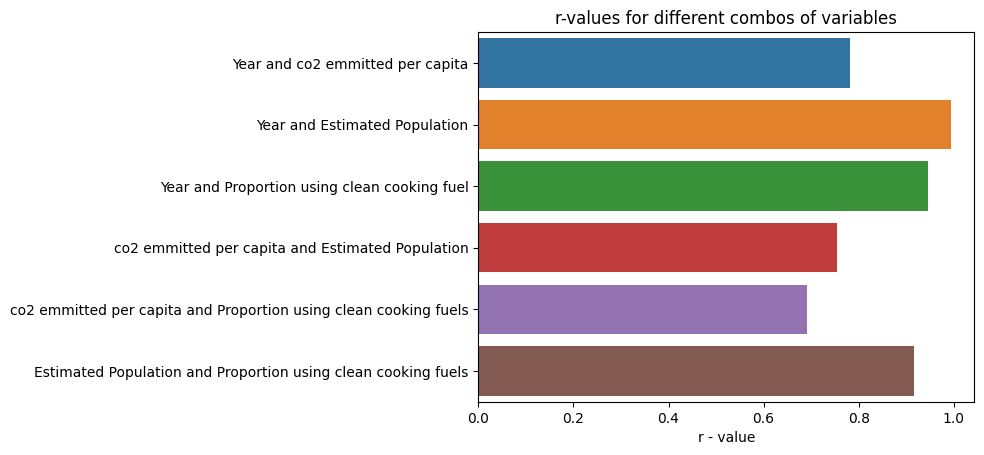

In [23]:
#Figure 4
ax = sns.barplot(data = r_df, orient = 'h')
ax.set_title('r-values for different combos of variables')
ax.set_xlabel('r - value')

In [24]:
#Model
fuel_access_df = fuel_access_grouped.reset_index()
fuel_access_df.columns = ['Year', 'fuel_access']

train = fuel_access_df.sample(frac=0.8, random_state=57)
test = fuel_access_df.drop(index=train.index)

X_train = train[['Year']]
y_train = train['fuel_access']
X_test = test[['Year']]
y_test = test['fuel_access']

lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)

print('Train score:', lr.score(X_train, y_train))
print('Test score:', lr.score(X_test, y_test))

coefs = pd.DataFrame(lr.coef_, index=['Year'], columns=['Coefficient vals'])
print(coefs)


Train score: 0.9989189690919562
Test score: 0.9941401001873487
      Coefficient vals
Year          0.548831
